# assignment 1

## made by Casper Hansen and Wanda Wannelöf 

In [23]:
# step 1
import pandas as pd
from sklearn.model_selection import train_test_split
  
# Read the CSV file.
data = pd.read_csv("CTG.csv", skiprows=1)

# Select the relevant numerical columns.
selected_cols = ['LB', 'AC', 'FM', 'UC', 'DL', 'DS', 'DP', 'ASTV', 'MSTV', 'ALTV',
                 'MLTV', 'Width', 'Min', 'Max', 'Nmax', 'Nzeros', 'Mode', 'Mean',
                 'Median', 'Variance', 'Tendency', 'NSP']
data = data[selected_cols].dropna()

# Shuffle the dataset.
data_shuffled = data.sample(frac=1.0, random_state=0)

# Split into input part X and output part Y.
X = data_shuffled.drop('NSP', axis=1)

# Map the diagnosis code to a human-readable label.
def to_label(y):
    return [None, 'normal', 'suspect', 'pathologic'][(int(y))]

Y = data_shuffled['NSP'].apply(to_label)

# Partition the data into training and test sets.
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2, random_state=69)


# look at the data 
X.head()

,LB,AC,FM,UC,DL,DS,DP,ASTV,MSTV,ALTV,...,Width,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency
658,130.0,1.0,0.0,3.0,0.0,0.0,0.0,24.0,1.2,12.0,...,35.0,120.0,155.0,1.0,0.0,134.0,133.0,135.0,1.0,0.0
1734,134.0,9.0,1.0,8.0,5.0,0.0,0.0,59.0,1.2,0.0,...,109.0,80.0,189.0,6.0,0.0,150.0,146.0,150.0,33.0,0.0
1226,125.0,1.0,0.0,4.0,0.0,0.0,0.0,43.0,0.7,31.0,...,21.0,120.0,141.0,0.0,0.0,131.0,130.0,132.0,1.0,0.0
1808,143.0,0.0,0.0,1.0,0.0,0.0,0.0,69.0,0.3,6.0,...,27.0,132.0,159.0,1.0,0.0,145.0,144.0,146.0,1.0,0.0
825,152.0,0.0,0.0,4.0,0.0,0.0,0.0,62.0,0.4,59.0,...,25.0,136.0,161.0,0.0,0.0,159.0,156.0,158.0,1.0,1.0


In [ ]:
# step 2
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score
#lets create a dummy classifier
clf = DummyClassifier(strategy='most_frequent')
# test the classifier
cross_val_score(clf, Xtrain, Ytrain)

array([0.77352941, 0.77352941, 0.77058824, 0.77058824, 0.77058824])

In [ ]:
# step 3
#import a bunch of other classifiers
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
MAX_ITER = 100
# create a dictionary of classifiers
clfs = {
    'Decision Tree at 10': DecisionTreeClassifier(max_depth=10, random_state=69),
     'Decision Tree at 5': DecisionTreeClassifier(max_depth=5, random_state=69),
    'Random Forest': RandomForestClassifier(random_state=69),
    'Gradient Boosting': GradientBoostingClassifier(random_state=69),
    'Neural Network at (100,50)': MLPClassifier(hidden_layer_sizes=(100, 50), random_state=69),
    'Neural Network at (10,500)': MLPClassifier(hidden_layer_sizes=(10, 500), random_state=69),

}

# step 4
# loop through the classifiers and test them
for name, clf in clfs.items():
    score= cross_val_score(clf, Xtrain, Ytrain)
    print("----------------------------------")
    print(f'{name}: {score.mean()}')
    print("----------------------------------")

print("done")
print("picked gradient boosting")
from sklearn.metrics import accuracy_score
clf = GradientBoostingClassifier()
clf.fit(Xtrain, Ytrain)
Yguess = clf.predict(Xtest)
print("accuracy score")
print(accuracy_score(Ytest, Yguess))



----------------------------------
Decision Tree at 10: 0.9258823529411766
----------------------------------
----------------------------------
Decision Tree at 5: 0.9282352941176472
----------------------------------
----------------------------------
Random Forest: 0.9394117647058824
----------------------------------
----------------------------------
Gradient Boosting: 0.9529411764705882
----------------------------------
----------------------------------
Neural Network at (100,50): 0.8800000000000001
----------------------------------
----------------------------------
Neural Network at (10,500): 0.871764705882353
----------------------------------
done
picked gradient boosting
accuracy score
0.9530516431924883


# Choice of Classifier
After testing all of the classifiers we landed on using the Gradient Boosting classifier since that one remained on top even though we tried tuning the hyperparameters of the desision tree and neural network (here we ran out of memory). 
- Decision Tree at 10: 0.9258823529411766  
- Decision Tree at 5: 0.9282352941176472  
- Random Forest: 0.9394117647058824  
- Gradient Boosting: 0.9529411764705882  
- Neural Network at (100,50): 0.8800000000000001  
- Neural Network at (10,500): 0.871764705882353  
## Gradient Boosting Description
The gradient boositng algorithm uses a number of descision trees or other similar algorithms which correct the mistakes (or at least makes an attempt to) of the previous model. Each model is trained to minimize the gradient (a measure of the error) of the loss function. The final model is a combination of all the models.
 



# assignment 2

In [24]:
## import the tree calssifier
from collections import Counter
from graphviz import Digraph
from sklearn.base import BaseEstimator, ClassifierMixin
from abc import ABC, abstractmethod
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score


def majority_sum_scorer(n_low, low_distr, n_high, high_distr):
    maj_sum_low = low_distr.most_common(1)[0][1]
    maj_sum_high = high_distr.most_common(1)[0][1]
    return maj_sum_low + maj_sum_high
    
def entropy(distr):
    n = sum(distr.values())
    ps = [n_i/n for n_i in distr.values()]
    return -sum(p*np.log2(p) if p > 0 else 0 for p in ps)

def info_gain_scorer(n_low, low_distr, n_high, high_distr):
    return -(n_low*entropy(low_distr)+n_high*entropy(high_distr))/(n_low+n_high)

def gini_impurity(distr):
    n = sum(distr.values())
    ps = [n_i/n for n_i in distr.values()]
    return 1-sum(p**2 for p in ps)
    
def gini_scorer(n_low, low_distr, n_high, high_distr):
    return -(n_low*gini_impurity(low_distr)+n_high*gini_impurity(high_distr))/(n_low+n_high)


class DecisionTreeLeaf:

    def __init__(self, value):
        self.value = value

    # This method computes the prediction for this leaf node. This will just return a constant value.
    def predict(self, x):
        return self.value

    # Utility function to draw a tree visually using graphviz.
    def draw_tree(self, graph, node_counter, names):
        node_id = str(node_counter)
        val_str = f'{self.value:.4g}' if isinstance(self.value, float) else str(self.value)
        graph.node(node_id, val_str, style='filled')
        return node_counter+1, node_id
        
    def __eq__(self, other):
        if isinstance(other, DecisionTreeLeaf):
            return self.value == other.value
        else:
            return False
class DecisionTreeBranch:

    def __init__(self, feature, threshold, low_subtree, high_subtree):
        self.feature = feature
        self.threshold = threshold
        self.low_subtree = low_subtree
        self.high_subtree = high_subtree

    # For a branch node, we compute the prediction by first considering the feature, and then 
    # calling the upper or lower subtree, depending on whether the feature is or isn't greater
    # than the threshold.
    def predict(self, x):
        if x[self.feature] <= self.threshold:
            return self.low_subtree.predict(x)
        else:
            return self.high_subtree.predict(x)

    # Utility function to draw a tree visually using graphviz.
    def draw_tree(self, graph, node_counter, names):
        node_counter, low_id = self.low_subtree.draw_tree(graph, node_counter, names)
        node_counter, high_id = self.high_subtree.draw_tree(graph, node_counter, names)
        node_id = str(node_counter)
        fname = f'F{self.feature}' if names is None else names[self.feature]
        lbl = f'{fname} > {self.threshold:.4g}?'
        graph.node(node_id, lbl, shape='box', fillcolor='yellow', style='filled, rounded')
        graph.edge(node_id, low_id, 'False')
        graph.edge(node_id, high_id, 'True')
        return node_counter+1, node_id
        
class DecisionTree(ABC, BaseEstimator):

    def __init__(self, max_depth):
        super().__init__()
        self.max_depth = max_depth
        
    # As usual in scikit-learn, the training method is called *fit*. We first process the dataset so that
    # we're sure that it's represented as a NumPy matrix. Then we call the recursive tree-building method
    # called make_tree (see below).
    def fit(self, X, Y):
        if isinstance(X, pd.DataFrame):
            self.names = X.columns
            X = X.to_numpy()
        elif isinstance(X, list):
            self.names = None
            X = np.array(X)
        else:
            self.names = None
        Y = np.array(Y)        
        self.root = self.make_tree(X, Y, self.max_depth)
        
    def draw_tree(self):
        graph = Digraph()
        self.root.draw_tree(graph, 0, self.names)
        return graph
    
    # By scikit-learn convention, the method *predict* computes the classification or regression output
    # for a set of instances.
    # To implement it, we call a separate method that carries out the prediction for one instance.
    def predict(self, X):
        if isinstance(X, pd.DataFrame):
            X = X.to_numpy()
        return [self.predict_one(x) for x in X]

    # Predicting the output for one instance.
    def predict_one(self, x):
        return self.root.predict(x)        

    # This is the recursive training 
    def make_tree(self, X, Y, max_depth):

        # We start by computing the default value that will be used if we'll return a leaf node.
        # For classifiers, this will be the most common value in Y.
        default_value = self.get_default_value(Y)

        # First the two base cases in the recursion: is the training set completely
        # homogeneous, or have we reached the maximum depth? Then we need to return a leaf.

        # If we have reached the maximum depth, return a leaf with the majority value.
        if max_depth == 0:
            return DecisionTreeLeaf(default_value)

        # If all the instances in the remaining training set have the same output value,
        # return a leaf with this value.
        if self.is_homogeneous(Y):
            return DecisionTreeLeaf(default_value)

        # Select the "most useful" feature and split threshold. To rank the "usefulness" of features,
        # we use one of the classification or regression criteria.
        # For each feature, we call best_split (defined in a subclass). We then maximize over the features.
        n_features = X.shape[1]
        _, best_feature, best_threshold = max(self.best_split(X, Y, feature) for feature in range(n_features))
        
        if best_feature is None:
            return DecisionTreeLeaf(default_value)

        # Split the training set into subgroups, based on whether the selected feature is greater than
        # the threshold or not
        X_low, X_high, Y_low, Y_high = self.split_by_feature(X, Y, best_feature, best_threshold)

        # Build the subtrees using a recursive call. Each subtree is associated
        # with a value of the feature.
        low_subtree = self.make_tree(X_low, Y_low, max_depth-1)
        high_subtree = self.make_tree(X_high, Y_high, max_depth-1)

        if low_subtree == high_subtree:
            return low_subtree

        # Return a decision tree branch containing the result.
        return DecisionTreeBranch(best_feature, best_threshold, low_subtree, high_subtree)
    
    # Utility method that splits the data into the "upper" and "lower" part, based on a feature
    # and a threshold.
    def split_by_feature(self, X, Y, feature, threshold):
        low = X[:,feature] <= threshold
        high = ~low
        return X[low], X[high], Y[low], Y[high]
    
    # The following three methods need to be implemented by the classification and regression subclasses.
    
    @abstractmethod
    def get_default_value(self, Y):
        pass

    @abstractmethod
    def is_homogeneous(self, Y):
        pass

    @abstractmethod
    def best_split(self, X, Y, feature):
        pass


class TreeClassifier(DecisionTree, ClassifierMixin):

    def __init__(self, max_depth=10, criterion='maj_sum'):
        super().__init__(max_depth)
        self.criterion = criterion
        
    def fit(self, X, Y):
        # For decision tree classifiers, there are some different ways to measure
        # the homogeneity of subsets.
        if self.criterion == 'maj_sum':
            self.criterion_function = majority_sum_scorer
        elif self.criterion == 'info_gain':
            self.criterion_function = info_gain_scorer
        elif self.criterion == 'gini':
            self.criterion_function = gini_scorer
        else:
            raise Exception(f'Unknown criterion: {self.criterion}')
        super().fit(X, Y)
        self.classes_ = sorted(set(Y))

    # Select a default value that is going to be used if we decide to make a leaf.
    # We will select the most common value.
    def get_default_value(self, Y):
        self.class_distribution = Counter(Y)
        return self.class_distribution.most_common(1)[0][0]
    
    # Checks whether a set of output values is homogeneous. In the classification case, 
    # this means that all output values are identical.
    # We assume that we called get_default_value just before, so that we can access
    # the class_distribution attribute. If the class distribution contains just one item,
    # this means that the set is homogeneous.
    def is_homogeneous(self, Y):
        return len(self.class_distribution) == 1
        
    # Finds the best splitting point for a given feature. We'll keep frequency tables (Counters)
    # for the upper and lower parts, and then compute the impurity criterion using these tables.
    # In the end, we return a triple consisting of
    # - the best score we found, according to the criterion we're using
    # - the id of the feature
    # - the threshold for the best split
    def best_split(self, X, Y, feature):

        # Create a list of input-output pairs, where we have sorted
        # in ascending order by the input feature we're considering.
        sorted_indices = np.argsort(X[:, feature])        
        X_sorted = list(X[sorted_indices, feature])
        Y_sorted = list(Y[sorted_indices])

        n = len(Y)

        # The frequency tables corresponding to the parts *before and including*
        # and *after* the current element.
        low_distr = Counter()
        high_distr = Counter(Y)

        # Keep track of the best result we've seen so far.
        max_score = -np.inf
        max_i = None

        # Go through all the positions (excluding the last position).
        for i in range(0, n-1):

            # Input and output at the current position.
            x_i = X_sorted[i]
            y_i = Y_sorted[i]
            
            # Update the frequency tables.
            low_distr[y_i] += 1
            high_distr[y_i] -= 1

            # If the input is equal to the input at the next position, we will
            # not consider a split here.
            #x_next = XY[i+1][0]
            x_next = X_sorted[i+1]
            if x_i == x_next:
                continue

            # Compute the homogeneity criterion for a split at this position.
            score = self.criterion_function(i+1, low_distr, n-i-1, high_distr)

            # If this is the best split, remember it.
            if score > max_score:
                max_score = score
                max_i = i

        # If we didn't find any split (meaning that all inputs are identical), return
        # a dummy value.
        if max_i is None:
            return -np.inf, None, None

        # Otherwise, return the best split we found and its score.
        split_point = 0.5*(X_sorted[max_i] + X_sorted[max_i+1])
        return max_score, feature, split_point

In [32]:
## Tune the hyperparameter max_depth:)

optimal_depth = 0
otimal_score = 0
clf = TreeClassifier(max_depth=0)
for depth in range(1, 10):
    clf.max_depth = depth
    score = cross_val_score(clf, Xtrain, Ytrain)
    if score.mean() > otimal_score:
        otimal_score = score.mean()
        optimal_depth = depth

print(f'Optimal depth: {optimal_depth}')
print(f'Optimal score: {otimal_score}')


Optimal depth: 5
Optimal score: 0.9064705882352943


Picked a max depth of 5
Optimal score was 0.9064705882352943



In [33]:
from sklearn.metrics import accuracy_score
clf = TreeClassifier(max_depth=5)
clf.fit(Xtrain, Ytrain)
Yguess = clf.predict(Xtest)
print("accuracy score at 5")
print(accuracy_score(Ytest, Yguess))

accuracy score at 5
0.9225352112676056


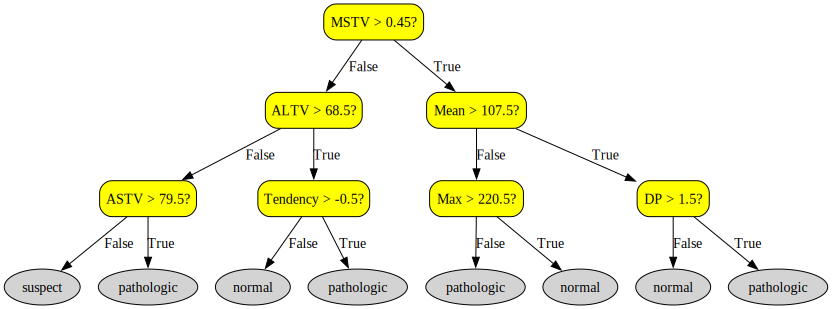

In [28]:
#drawign the tree
clf = TreeClassifier(max_depth=3)
clf.fit(Xtrain, Ytrain)
clf.draw_tree()


# Optimal Hyperparameters
- depth = 5
- score = 0.9064705882352943
- accuracy = 0.9225352112676056

# Assignment 3


In [29]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Read the Excel file using Pandas.
housedata = pd.read_excel('Hemnet_data.xlsx')

# # Convert the timestamp string to an integer representing the year.
housedata['year'] = pd.DatetimeIndex(housedata['Sold Date']).year

# Convert 'yes' to 1 and 'no' to 0
housedata['Balcony'] = housedata['Balcony'].map({'Yes': 1, 'No': 0})
housedata['Patio'] = housedata['Patio'].map({'Yes': 1, 'No': 0})
housedata['Lift'] = housedata['Lift'].map({'Yes': 1, 'No': 0})

# Select the 12 input columns and the output column.
selected_columns = ['Final Price (kr)', 'year',  'Num of Room', 'Living Area (m²)', 'Balcony', 'Patio','Current Floor', 'Total Floor', 'Lift', 'Built Year', 'Fee (kr/month)', 'Operating Fee (kr/year)']
housedata = housedata[selected_columns]
housedata = housedata.dropna()

# Shuffle.
alldata_shuffled = housedata.sample(frac=1.0, random_state=0)

# Separate the input and output columns.
X = alldata_shuffled.drop('Final Price (kr)', axis=1)
# For the output, we'll use the log of the sales price.
Y = alldata_shuffled['Final Price (kr)'].apply(np.log)

# Split into training and test sets.
XtrainHouse, XtestHouse, YtrainHouse, YtestHouse = train_test_split(X, Y, test_size=0.2, random_state=0)
## fix some error
if 'Fee (kr/month)' in XtrainHouse.columns:
                    XtrainHouse['Fee (kr/month)'] = XtrainHouse['Fee (kr/month)'].replace('[^0-9]', '', regex=True).astype(float)
                    XtestHouse['Fee (kr/month)'] = XtestHouse['Fee (kr/month)'].replace('[^0-9]', '', regex=True).astype(float)


In [8]:
## testing numeric values for cross validation
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_validate
m1 = DummyRegressor()
cross_validate(m1, XtrainHouse, YtrainHouse, scoring='neg_mean_squared_error')

{'fit_time': array([0.00121593, 0.00112939, 0.00087953, 0.00080156, 0.00083613]),
 'score_time': array([0.00053072, 0.00039744, 0.00039577, 0.00034928, 0.0003643 ]),
 'test_score': array([-0.35548711, -0.35827597, -0.31759722, -0.34236524, -0.35596055])}

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_validate
import math



optimal_depth = 1
optimal_estimator = 0
optimal_layer_size = 0
optimal_alpha = 0
optimal_score = 100
regs = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=69),
    'Random Forest': RandomForestRegressor(random_state=69),
    'Gradient Boosting': GradientBoostingRegressor(random_state=69),
    'Neural Network': MLPRegressor(random_state=69), 
    'Lasso': Lasso(random_state=69),
    'Ridge': Ridge(random_state=69)
}

## find the optimal hyperparams for the regressors
print("Finding optimal hyperparameters")
# Decision Tree
print("Decision Tree")
def update_optimal_depth(optimal_score, depth, score):
    if abs(score['test_score'].mean()) < abs(optimal_score):
        optimal_score = score['test_score'].mean()
        optimal_depth = depth
    return optimal_depth

def update_optimal_estimator(optimal_score, regs, estimator):
    score = cross_validate(regs['Random Forest'], XtrainHouse, YtrainHouse, scoring='neg_mean_squared_error')
  
    if abs(score['test_score'].mean()) < abs(optimal_score):
        optimal_score = score['test_score'].mean()
        optimal_estimator = estimator
    return optimal_estimator


for depth in range(1, 10):
    regs['Decision Tree'].max_depth = depth
    score = cross_validate(regs['Decision Tree'], XtrainHouse, YtrainHouse, scoring='neg_mean_squared_error')
    optimal_depth = update_optimal_depth(optimal_score, depth, score)
regs['Decision Tree'].max_depth = optimal_depth
print(f'Optimal depth: {optimal_depth}')



print("Random Forest")
optimal_score = 100
optimal_depth = 0
optimal_estimator = 0
# Random Forest
for depth in range(1,10):
    regs['Random Forest'].max_depth = depth
    optimal_depth = update_optimal_depth(optimal_score, depth, score)
print(f'Optimal depth: {optimal_depth}')


optimal_score = 100
for estimator in range(10, 110, 10):
    regs['Random Forest'].n_estimators = estimator
    optimal_estimator = update_optimal_estimator(optimal_score, regs, estimator)

print(f'Optimal estimator: {optimal_estimator}')

regs['Random Forest'].n_estimators = optimal_estimator
regs['Random Forest'].max_depth = optimal_depth



print("Gradient Boosting")
# Gradient Boosting
optimal_score = 100
optimal_depth = 0
optimal_estimator = 0
for estimator in range(10, 100, 10):
    regs['Gradient Boosting'].n_estimators = estimator
    optimal_estimator = update_optimal_estimator(optimal_score, regs, estimator)

optimal_score = 100
for depth in range(1,10):
    regs['Gradient Boosting'].max_depth = depth
    optimal_depth = update_optimal_depth(optimal_score, depth, score)

print(f'Optimal estimator: {optimal_estimator}')
print(f'Optimal depth: {optimal_depth}')
regs['Gradient Boosting'].n_estimators = optimal_estimator
regs['Gradient Boosting'].max_depth = optimal_depth


print ("Lasso and Ridge")
## lasso and ridge
optimal_score = 100
for alpha in np.arange(0.1, 1, 0.1):
    regs['Lasso'].alpha = alpha
    score = cross_validate(regs['Lasso'], XtrainHouse, YtrainHouse, scoring='neg_mean_squared_error')
    if abs(score['test_score'].mean()) < abs(optimal_score):
        optimal_score = score['test_score'].mean()
        optimal_alpha = alpha
regs['Lasso'].alpha = optimal_alpha
print (f'Optimal alpha Lasso: {optimal_alpha}')
optimal_score = 100
for alpha in np.arange(0.1, 1, 0.1):
    regs['Ridge'].alpha = alpha
    score = cross_validate(regs['Ridge'], XtrainHouse, YtrainHouse, scoring='neg_mean_squared_error')
    if abs(score['test_score'].mean()) < abs(optimal_score):
        optimal_score = score['test_score'].mean()
        optimal_alpha = alpha

regs['Ridge'].alpha = optimal_alpha
print (f'Optimal alpha Ridge: {optimal_alpha}')

print("comparing regressors")
## now lets compare regressors
optimal_score = 100
optimal_reg = None
for name, reg in regs.items():
    score = cross_validate(reg, XtrainHouse, YtrainHouse, scoring='neg_mean_squared_error')
    print(f'{name}: {score["test_score"].mean()}')
    if abs(score['test_score'].mean()) < abs(optimal_score):
        optimal_score = score['test_score'].mean()
        optimal_reg = name

print(f'Optimal regressor: {optimal_reg}')
print (f'Optimal score: {optimal_score}')

Finding optimal hyperparameters
Decision Tree
Optimal depth: 9
Random Forest
Optimal depth: 9
Optimal estimator: 100
Gradient Boosting
Optimal estimator: 90
Optimal depth: 9
Lasso and Ridge
Optimal alpha Lasso: 0.1
Optimal alpha Ridge: 0.9
comparing regressors
Linear Regression: -0.22044055517560962
Decision Tree: -0.19552683244067154
Random Forest: -0.15960733607981253
Gradient Boosting: -0.1522798203566916
Neural Network: -20.303110724067874
Lasso: -0.2579509437138855
Ridge: -0.22043976532548987
Optimal regressor: Gradient Boosting
Optimal score: -0.1522798203566916


The optimal Regressor was Gradient Boosting with a max depth of 9 and 90 estimatorss. The score was -0.1522798203566916
We tried:
- Linear Regression: -0.22044055517560937
- Decision Tree: -0.19552683244067154
- Random Forest: -0.15960733607981253
- Gradient Boosting: -0.1522798203566916
- Neural Network: -20.303110724171958
- Lasso: -0.2579509437138855
- Ridge: -0.22043976532548956
- Optimal regressor: Gradient Boosting
- Optimal score: -0.1522798203566916

- Decision Tree  
    - Optimal depth: 9  
- Random Forest  
    - Optimal depth: 9  
    - Optimal estimator: 100  
- Gradient Boosting  
    - Optimal estimator: 90  
    - Optimal depth: 9  
- Lasso and Ridge  
    - Optimal alpha Lasso: 0.1  
    - Optimal alpha Ridge: 0.9  


In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
regr = GradientBoostingRegressor(n_estimators=90, max_depth=9, random_state=69)
regr.fit(XtrainHouse, YtrainHouse)
mean_squared_error(YtestHouse, regr.predict(XtestHouse))

0.13786071377982884

The mse was 0.13786071377982884

# assignment 4

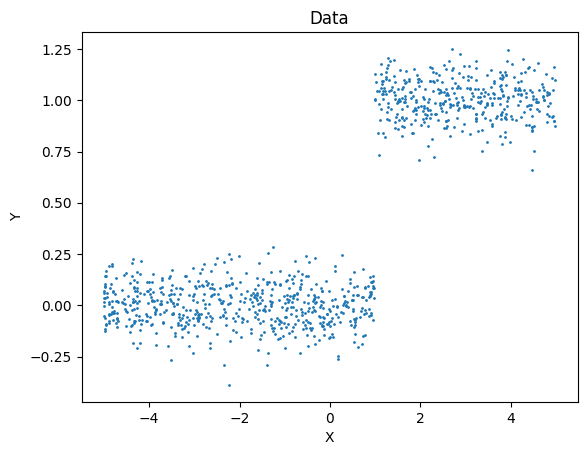

In [30]:
# step 1
from sklearn.base import RegressorMixin
from sklearn.tree import DecisionTreeRegressor

class TreeRegressor(DecisionTree, RegressorMixin):
    def __init__(self, max_depth=1000, criterion='variance_reduction', variance=0.01):
        super().__init__(max_depth=max_depth)  # Pass max_depth to the parent class
        self.criterion = criterion
        self.variance = variance

    def fit(self, X, Y):
        if self.criterion != 'variance_reduction':
            raise Exception(f'Unknown criterion: {self.criterion}')
        super().fit(X, Y)

    def get_default_value(self, Y):
        return np.mean(Y)

    def is_homogeneous(self, Y):
        if len(Y) <= 2:
            return True
        return np.var(Y) <= self.variance

    # - the threshold for the best split
    def best_split(self, X, Y, feature):

        # Create a list of input-output pairs, where we have sorted
        # in ascending order by the input feature we're considering.
        sorted_indices = np.argsort(X[:, feature])        
        X_sorted = list(X[sorted_indices, feature])
        Y_sorted = list(Y[sorted_indices])

        n = len(Y)
        sum = np.sum(Y_sorted)
        sum_sq = np.sum(np.square(Y_sorted))

        # The sums and squares of the outputs corresponding to the parts *before and including* 
        # and *after* the current element.
        low_sum = 0.0
        low_sum_sq = 0.0
        low_count = 0.0
        high_sum = np.sum(Y_sorted)
        high_sum_sq = np.sum(np.square(Y_sorted))
        high_count = n


        # Keep track of the best result we've seen so far.
        max_score = -np.inf
        max_i = None

        # Go through all the positions (excluding the last position).
        for i in range(0, n-1):

            # Input and output at the current position.
            x_i = X_sorted[i]
            y_i = Y_sorted[i]
            
            # Update the sums and squares.
            low_sum += y_i
            low_sum_sq += np.square(y_i)
            low_count += 1.0
            high_sum -= y_i
            high_sum_sq -= np.square(y_i)
            high_count -= 1.0

            


            # If the input is equal to the input at the next position, we will
            # not consider a split here.
            #x_next = XY[i+1][0]
            x_next = X_sorted[i+1]
            if x_i == x_next:
                continue



            # compute the homogeneity criterion for a split at this position using the variance reduction criterion.
            # the variance reduction is given by the formula:
            #   V_tot - V_low * n_low/n - V_high * n_high/n
            # where V  means variance for the different parts.

            V_tot = sum_sq/n - (sum/n) ** 2
            V_low = low_sum_sq/low_count - (low_sum/low_count) ** 2 if low_count > 0 else 0
            V_high = high_sum_sq/high_count - (high_sum/high_count) ** 2 if high_count > 0 else 0

            score = V_tot - (V_low * low_count/n + V_high * high_count/n)

            # if the score is negative, its cringe
            if score < 0:
                continue


            # If this is the best split, remember it.
            if score > max_score:
                max_score = score
                max_i = i

        # If we didn't find any split (meaning that all inputs are identical), return
        # a dummy value.
        if max_i is None:
            return -np.inf, None, None

        # Otherwise, return the best split we found and its score.
        split_point = 0.5*(X_sorted[max_i] + X_sorted[max_i+1])
        return max_score, feature, split_point
    

def make_some_data(n):
    x = np.random.uniform(-5, 5, size=n)
    Y = (x > 1) + 0.1*np.random.normal(size=n)
    X = x.reshape(n, 1) # X needs to be a 2-dimensional matrix
    return X, Y
data = make_some_data(1000)
X = data[0]
Y = data[1]

# plot 
import matplotlib.pyplot as plt
import numpy as np

# plot it 
plt.scatter(X, Y, s=1)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Data')
plt.show()


We would like to have a shallow tree because the data is well defined inttwo splits and we dont want it traning on the noise

Good tree


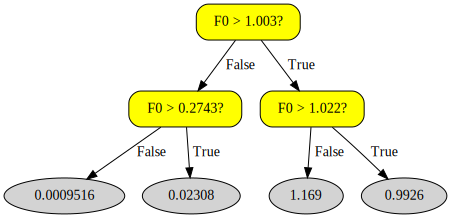

In [ ]:

#step 2(ish)

print("Good tree")
reg =  TreeRegressor(max_depth=2, variance=0.001)

reg.fit(data[0], data[1])
reg.draw_tree()



Large tree


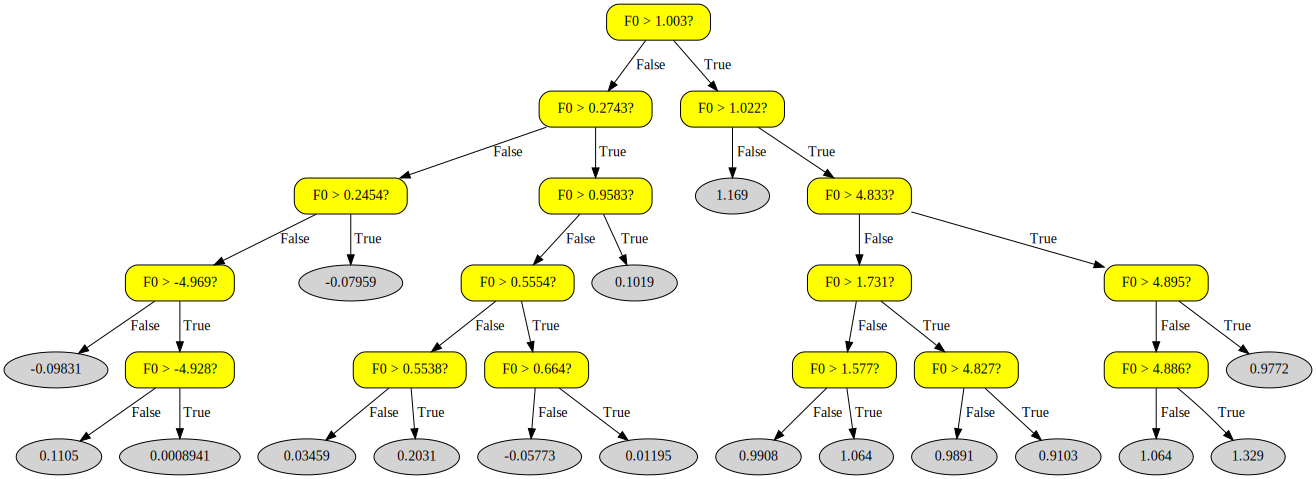

In [19]:
print ("Large tree")

reg = TreeRegressor(max_depth=5, variance=0.009)

reg.fit(data[0], data[1])
reg.draw_tree()

## Conclusions
- the good tree makes a fairly good estimate with a big split at f0>1. It almost starts overfitting even after that because it starts getting very granual in its answers

- using a large tree you can see that it fits to a lot of noise. The tree is very complex and it memorizes datapoints. 

- would like to try to regularize the model to avoid overfitting :)

mean squared error: 0.1718542794653894
r**2 Score: 0.48938438554611596


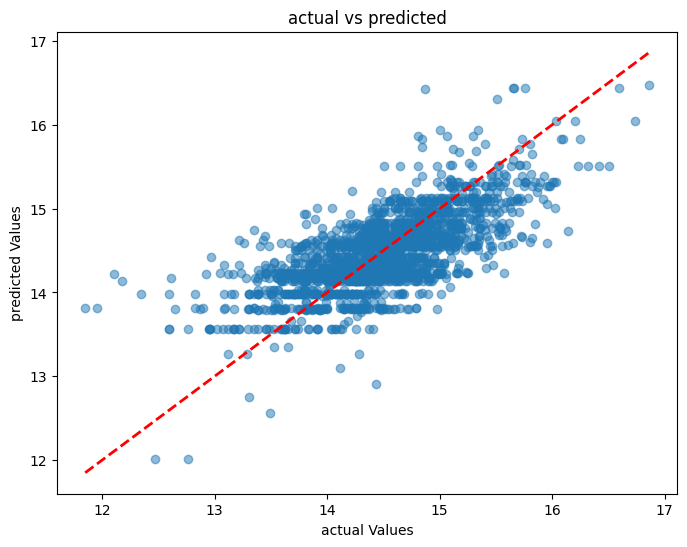

In [31]:
from sklearn.metrics import r2_score
#step 3

import matplotlib.pyplot as plt

depth = 8
# Train the TreeRegressor
reg = TreeRegressor(max_depth = depth, variance=0.001)
reg.fit(XtrainHouse, YtrainHouse)

# Predict on the test data
Yguess = reg.predict(XtestHouse)
# Yguess_train = reg.predict(XtrainHouse)

mse = mean_squared_error(YtestHouse, Yguess)
# mse_train = mean_squared_error(YtrainHouse, Yguess_train)
print("mean squared error:", mse)
# print("Mean Squared Error:", mse_train)

r2 = r2_score(YtestHouse, Yguess)
# r2_train = r2_score(YtrainHouse, Yguess_train)
print("r**2 Score:", r2)
# print("R² Test Score:", r2_train)

# Plot actual vs predicted values
plt.figure(figsize=(8, 6))
plt.scatter(YtestHouse, Yguess, alpha=0.5)
plt.plot([YtestHouse.min(), YtestHouse.max()], [YtestHouse.min(), YtestHouse.max()], 'r--', lw=2)
plt.xlabel("actual Values")
plt.ylabel("predicted Values")
plt.title("actual vs predicted")
plt.show()


# fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True)
# fig.set_figwidth(12)
# fig.suptitle(f"Depth = {depth}")
# ax1.scatter(YtestHouse, Yguess, alpha=0.5)
# ax1.set_title("Test Data")
# ax1.plot([YtestHouse.min(), YtestHouse.max()], [YtestHouse.min(), YtestHouse.max()], 'r--', lw=2)
# ax2.scatter(YtrainHouse, Yguess_train, alpha=0.5)
# ax2.set_title("Train Data")
# ax2.plot([YtrainHouse.min(), YtrainHouse.max()], [YtrainHouse.min(), YtrainHouse.max()], 'r--', lw=2)
# plt.show()



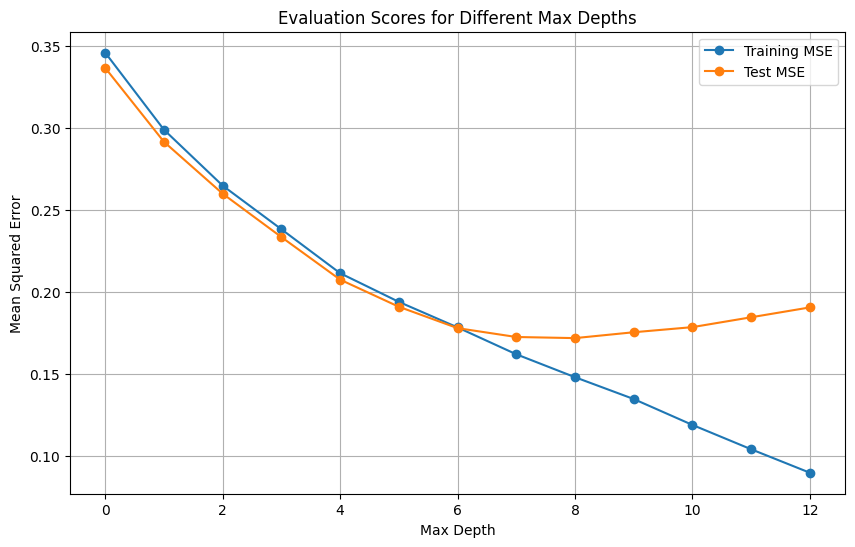

In [ ]:
# step 4
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

def plot_evaluation(Xtrain, Ytrain, Xtest, Ytest, max_depth_range):
    train_scores = []
    test_scores = []

    # loop over all depths
    for depth in max_depth_range:
        # train the TreeRegressor (arbitrary variance) 
        reg = TreeRegressor(max_depth=depth, variance=0.001)
        reg.fit(Xtrain, Ytrain)


        Ytrain_pred = reg.predict(Xtrain)
        Ytest_pred = reg.predict(Xtest)

        # compute mean squared error
        train_mse = mean_squared_error(Ytrain, Ytrain_pred)
        test_mse = mean_squared_error(Ytest, Ytest_pred)

        train_scores.append(train_mse)
        test_scores.append(test_mse)

    # plot
    plt.figure(figsize=(10, 6))
    plt.plot(max_depth_range, train_scores, label='Training MSE', marker='o')
    plt.plot(max_depth_range, test_scores, label='Test MSE', marker='o')
    plt.xlabel('Max Depth')
    plt.ylabel('Mean Squared Error')
    plt.title('Evaluation Scores for Different Max Depths')
    plt.legend()
    plt.grid()
    plt.show()

max_depth_max = range(0, 13)

# Call the function to plot the evaluation scores
plot_evaluation(XtrainHouse, YtrainHouse, XtestHouse, YtestHouse, max_depth_max)



As the depth increases the model starts to memorize the data. The generalisability decreases which means that it fits well to the exact training data but not to the test data. The model is overfitting. The split seems to happen around a depth of six which suggests this is the optimal depth. Here we get the least error but still good generalisability.